# 6. 뉴스 카테고리 다중분류
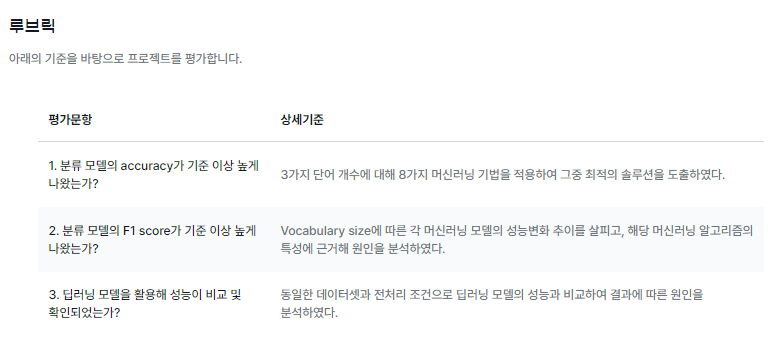

## 실험 및 결과 요약

### 모든 단어 vs 5000개 단어 정확도 비교
- 나이브 베이즈에서 5000개의 단어가 좀 더 좋음
- 다른건 큰 차이가 없어보임
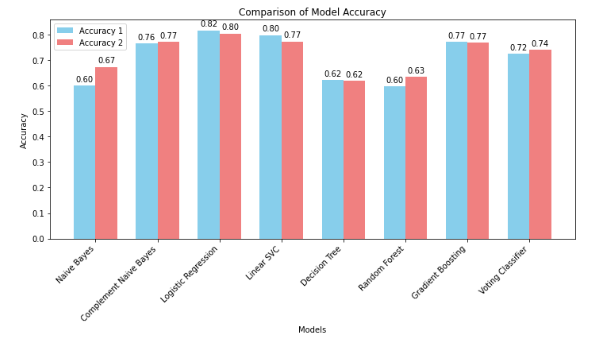


### 직접 설정한 단어를 15000 개 사용한 이유
- x : 빈도를 가지는 단어 개수
- y : 단어의 빈도 인덱스
- 데이터가 너무 깔끔해서 의심스러우나,, 우선 중앙값인 15000개로 선정
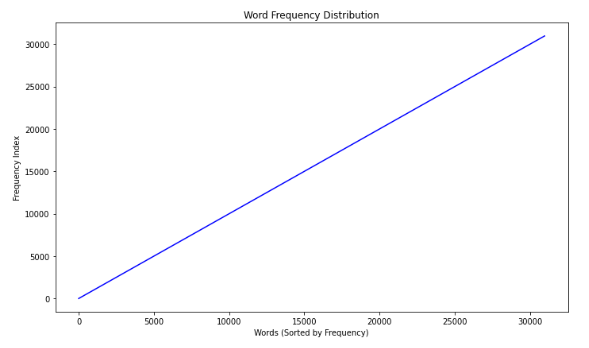

### 모든 단어 vs 5000개 vs 15000개 정확도 비교
- 나이브 베이즈에서만 좀 더 차이가 보임
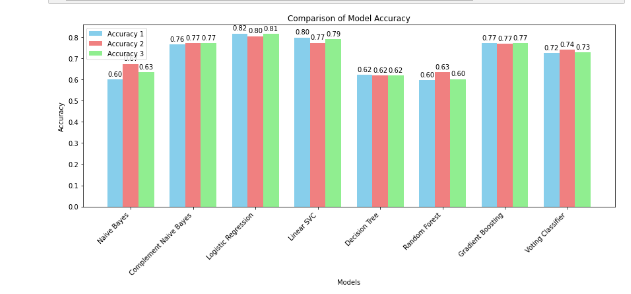

#### 회고
- 나이브 베이즈에서는 랜덤으로 선택된 직전 확률과만 비교할텐데 그냥 초기값 가챠 성공 같아 보였음
- 단어 개수에 대해 어떤 요소가 영향을 미친지 조금 더 고민해봐야 함
- 

-----

* 라이브러리 import

In [82]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# 1. 모든 단어 사용

## 1. 데이터 확인하기

* 단어 수에 따라 모델 성능이 어떻게 바뀌는지 실험

In [37]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

- 데이터 출력해보기

In [38]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [39]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

In [40]:
print(y_train[0])
print(y_test[0])

3
3


In [41]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


- 데이터 분포 확인해보기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


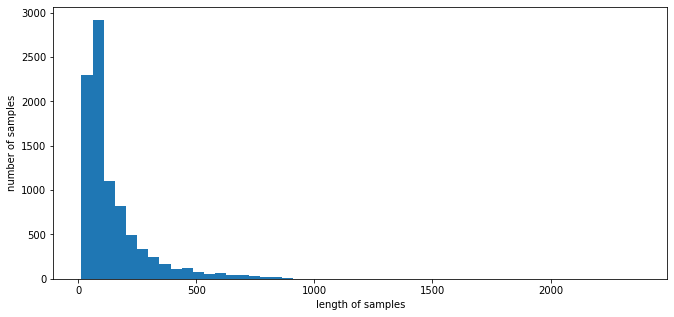

In [42]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

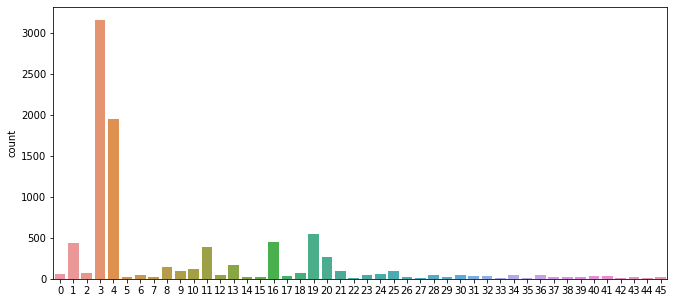

In [43]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [44]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


## 2. 데이터 복원하기

In [45]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print('=3')

=3


In [46]:
word_index['the']

1

In [47]:
word_index['it']

13

In [48]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [49]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [50]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [51]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [52]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [53]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


## 3. 벡터화 하기

- dtm 생성, dtm 크기 확인

In [54]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [55]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## - 나이브 베이즈 분류기

In [56]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [57]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_NB_1 = accuracy_score(y_test, predicted) #예측값과 실제값 비교
print("정확도:", acc_NB_1)


정확도: 0.5997328584149599


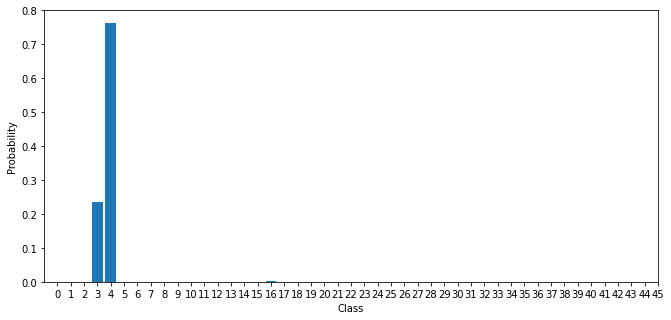

In [58]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [59]:
model.predict(tfidfv_test[3])

array([4])

## - F1-Score, Confusion Matrix

### Precision, Recall & F1 Score

In [60]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
          17       0.00    

### Confusion Matrix

In [61]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

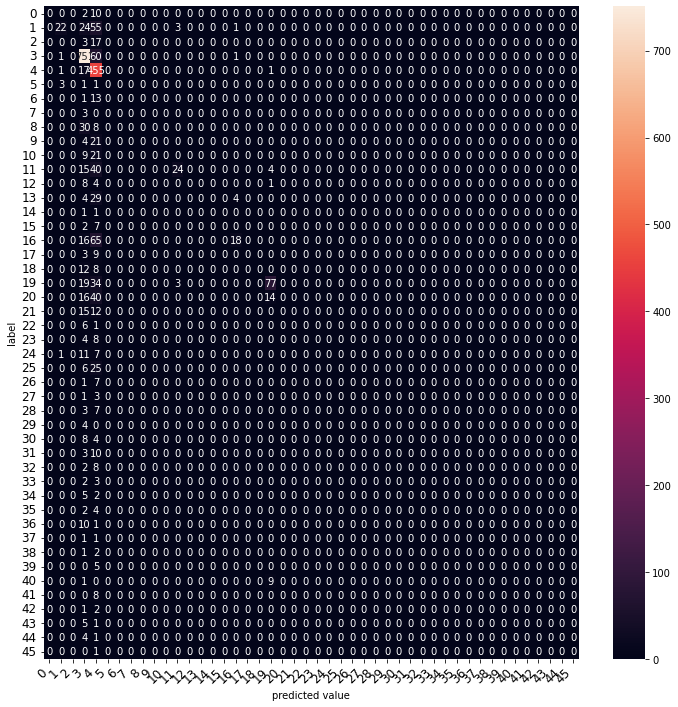

In [62]:
graph_confusion_matrix(model, tfidfv_test, y_test)

# 다양한 머신러닝 모델 사용

## Complement Naive Bayes Classifier(CNB)

In [66]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [67]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_cnb_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_cnb_1) #예측값과 실제값 비교

정확도: 0.7649154051647373


## 로지스틱 회귀(Logistic Regression)

In [68]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [69]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_lr_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_lr_1) #예측값과 실제값 비교

정확도: 0.8165627782724845


## 선형 서포트 벡터 머신(Linear Support Vector Machine)


In [70]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [71]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_lsvc_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_lsvc_1) #예측값과 실제값 비교

정확도: 0.7978628673196795


## 결정 트리(Decision Tree)

In [72]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [73]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_tree_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_tree_1) #예측값과 실제값 비교

정확도: 0.6211041852181657


## 랜덤 포레스트(Random Forest)

In [74]:
forest = RandomForestClassifier(max_depth = 10)
forest.fit(tfidfv, y_train)

RandomForestClassifier(max_depth=10)

In [75]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_forest_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_forest_1) #예측값과 실제값 비교

정확도: 0.5961709706144257


## 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [76]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [77]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_grbt_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_grbt_1) #예측값과 실제값 비교

정확도: 0.7702582368655387


## 보팅(Voting)

In [83]:
LGBM = LGBMClassifier()

XGB = XGBClassifier()

RF = RandomForestClassifier()

voting_classifier =  VotingClassifier(estimators=[('rf',RF),('xgb',XGB),('lgbm',LGBM)],voting = 'soft')
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:36:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                 

In [84]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_voting_1 = accuracy_score(y_test, predicted)
print("정확도:", acc_voting_1) #예측값과 실제값 비교

정확도: 0.7243989314336599


## 모든 단어 사용에 대한 모델 정확도

In [85]:
print("Accuracy of Naive Bayes:", acc_NB_1)
print("Accuracy of Complement Naive Bayes:", acc_cnb_1)
print("Accuracy of Logistic Regression:", acc_lr_1)
print("Accuracy of Linear SVC:", acc_lsvc_1)
print("Accuracy of Decision Tree:", acc_tree_1)
print("Accuracy of Random Forest:", acc_forest_1)
print("Accuracy of Gradient Boosting:", acc_grbt_1)
print("Accuracy of Voting Classifier:", acc_voting_1)


Accuracy of Naive Bayes: 0.5997328584149599
Accuracy of Complement Naive Bayes: 0.7649154051647373
Accuracy of Logistic Regression: 0.8165627782724845
Accuracy of Linear SVC: 0.7978628673196795
Accuracy of Decision Tree: 0.6211041852181657
Accuracy of Random Forest: 0.5961709706144257
Accuracy of Gradient Boosting: 0.7702582368655387
Accuracy of Voting Classifier: 0.7243989314336599


-----

# 2. 빈도수 상위 5000개 사용

## 1. 데이터 확인하기

* 단어 수에 따라 모델 성능이 어떻게 바뀌는지 실험

In [133]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

- 데이터 출력해보기

In [131]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [88]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [89]:
print(y_train[0])
print(y_test[0])

3
3


In [90]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


- 데이터 분포 확인해보기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


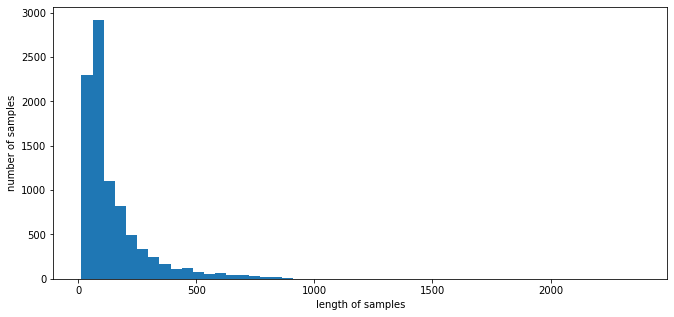

In [91]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

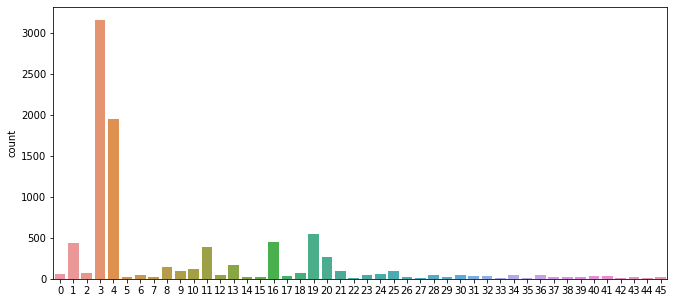

In [92]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [93]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


## 2. 데이터 복원하기

In [94]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print('=3')

=3


In [95]:
word_index['the']

1

In [96]:
word_index['it']

13

In [97]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [98]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [99]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [100]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [101]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [102]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


## 3. 벡터화 하기

- dtm 생성, dtm 크기 확인

In [103]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


In [104]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


## - 나이브 베이즈 분류기

In [105]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [106]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_NB_2 = accuracy_score(y_test, predicted) #예측값과 실제값 비교
print("정확도:", acc_NB_2)


정확도: 0.6731967943009796


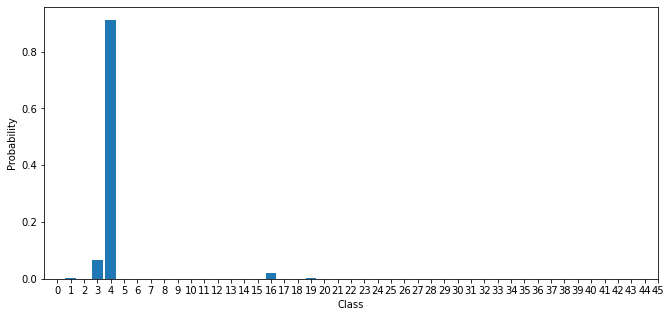

In [107]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [108]:
model.predict(tfidfv_test[3])

array([4])

## - F1-Score, Confusion Matrix

### Precision, Recall & F1 Score

In [109]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
          17       0.00    

### Confusion Matrix

In [110]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

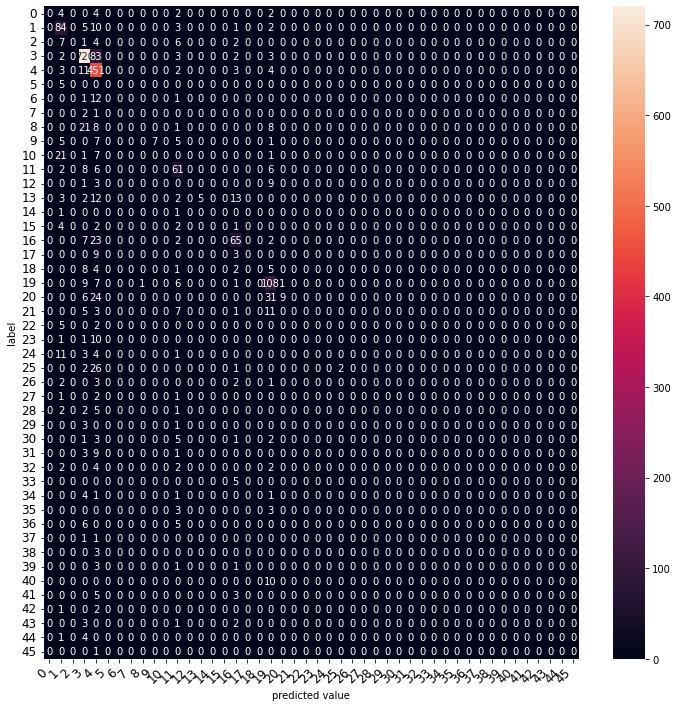

In [111]:
graph_confusion_matrix(model, tfidfv_test, y_test)

# 다양한 머신러닝 모델 사용

## Complement Naive Bayes Classifier(CNB)

In [112]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [113]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_cnb_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_cnb_2) #예측값과 실제값 비교

정확도: 0.7707034728406055


## 로지스틱 회귀(Logistic Regression)

In [114]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [115]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_lr_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_lr_2) #예측값과 실제값 비교

정확도: 0.8036509349955476


## 선형 서포트 벡터 머신(Linear Support Vector Machine)


In [116]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [117]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_lsvc_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_lsvc_2) #예측값과 실제값 비교

정확도: 0.7729296527159395


## 결정 트리(Decision Tree)

In [118]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [119]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_tree_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_tree_2) #예측값과 실제값 비교

정확도: 0.6179875333926982


## 랜덤 포레스트(Random Forest)

In [120]:
forest = RandomForestClassifier(max_depth = 10)
forest.fit(tfidfv, y_train)

RandomForestClassifier(max_depth=10)

In [121]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_forest_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_forest_2) #예측값과 실제값 비교

정확도: 0.6335707925200356


## 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [122]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [123]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_grbt_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_grbt_2) #예측값과 실제값 비교

정확도: 0.767586821015138


## 보팅(Voting)

In [124]:
LGBM = LGBMClassifier()

XGB = XGBClassifier()

RF = RandomForestClassifier()

voting_classifier =  VotingClassifier(estimators=[('rf',RF),('xgb',XGB),('lgbm',LGBM)],voting = 'soft')
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:06:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                 

In [125]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_voting_2 = accuracy_score(y_test, predicted)
print("정확도:", acc_voting_2) #예측값과 실제값 비교

정확도: 0.7404274265360641


## 5000개 단어에 대한 정확도

In [126]:
print("Accuracy of Naive Bayes:", acc_NB_2)
print("Accuracy of Complement Naive Bayes:", acc_cnb_2)
print("Accuracy of Logistic Regression:", acc_lr_2)
print("Accuracy of Linear SVC:", acc_lsvc_2)
print("Accuracy of Decision Tree:", acc_tree_2)
print("Accuracy of Random Forest:", acc_forest_2)
print("Accuracy of Gradient Boosting:", acc_grbt_2)
print("Accuracy of Voting Classifier:", acc_voting_2)

Accuracy of Naive Bayes: 0.6731967943009796
Accuracy of Complement Naive Bayes: 0.7707034728406055
Accuracy of Logistic Regression: 0.8036509349955476
Accuracy of Linear SVC: 0.7729296527159395
Accuracy of Decision Tree: 0.6179875333926982
Accuracy of Random Forest: 0.6335707925200356
Accuracy of Gradient Boosting: 0.767586821015138
Accuracy of Voting Classifier: 0.7404274265360641


# 모든 단어 vs 5000개 단어 정확도 비교

In [127]:
import pandas as pd

# 첫 번째 결과
results_1 = {
    "Naive Bayes": acc_NB_1,
    "Complement Naive Bayes": acc_cnb_1,
    "Logistic Regression": acc_lr_1,
    "Linear SVC": acc_lsvc_1,
    "Decision Tree": acc_tree_1,
    "Random Forest": acc_forest_1,
    "Gradient Boosting": acc_grbt_1,
    "Voting Classifier": acc_voting_1
}

# 두 번째 결과
results_2 = {
    "Naive Bayes": acc_NB_2,
    "Complement Naive Bayes": acc_cnb_2,
    "Logistic Regression": acc_lr_2,
    "Linear SVC": acc_lsvc_2,
    "Decision Tree": acc_tree_2,
    "Random Forest": acc_forest_2,
    "Gradient Boosting": acc_grbt_2,
    "Voting Classifier": acc_voting_2
}

# 데이터프레임 생성
df = pd.DataFrame({
    'Model': list(results_1.keys()),
    'Accuracy 1': list(results_1.values()),
    'Accuracy 2': list(results_2.values())
})

# 출력
print(df)


                    Model  Accuracy 1  Accuracy 2
0             Naive Bayes    0.599733    0.673197
1  Complement Naive Bayes    0.764915    0.770703
2     Logistic Regression    0.816563    0.803651
3              Linear SVC    0.797863    0.772930
4           Decision Tree    0.621104    0.617988
5           Random Forest    0.596171    0.633571
6       Gradient Boosting    0.770258    0.767587
7       Voting Classifier    0.724399    0.740427


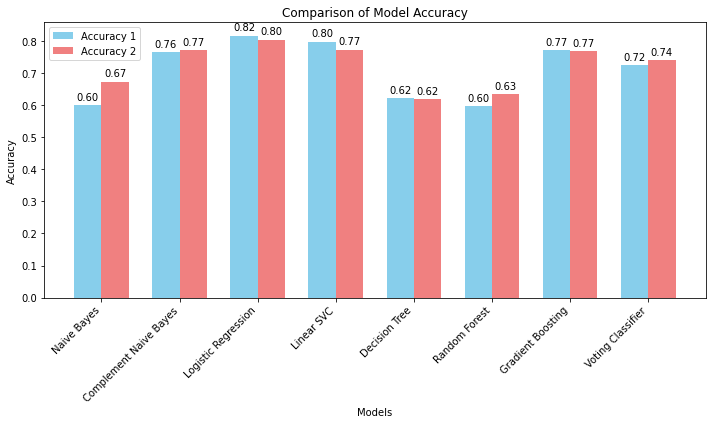

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 이름 리스트
models = ["Naive Bayes", "Complement Naive Bayes", "Logistic Regression", "Linear SVC", 
          "Decision Tree", "Random Forest", "Gradient Boosting", "Voting Classifier"]

# 첫 번째, 두 번째 결과값
accuracy_1 = [acc_NB_1, acc_cnb_1, acc_lr_1, acc_lsvc_1, acc_tree_1, acc_forest_1, acc_grbt_1, acc_voting_1]
accuracy_2 = [acc_NB_2, acc_cnb_2, acc_lr_2, acc_lsvc_2, acc_tree_2, acc_forest_2, acc_grbt_2, acc_voting_2]

# x축 위치 설정
x = np.arange(len(models))  # 모델의 개수만큼 위치 지정
width = 0.35  # 막대의 너비

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy_1, width, label='Accuracy 1', color='skyblue')
bars2 = ax.bar(x + width/2, accuracy_2, width, label='Accuracy 2', color='lightcoral')

# 제목과 축 라벨 설정
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")  # x축에 모델 이름 추가
ax.legend()

# 막대에 정확도 값 표시
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # 소수점 두 자리로 정확도 표시
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 텍스트 위치 조정
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# 레이아웃 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()


### 위 결과를 토대로 직접 단어 개수 설정

- 나이브 베이즈에서 빈도 5000 단어가 전체 단어보다 조금 더 정확도가 높은것 외엔 큰 차이가 없어보임


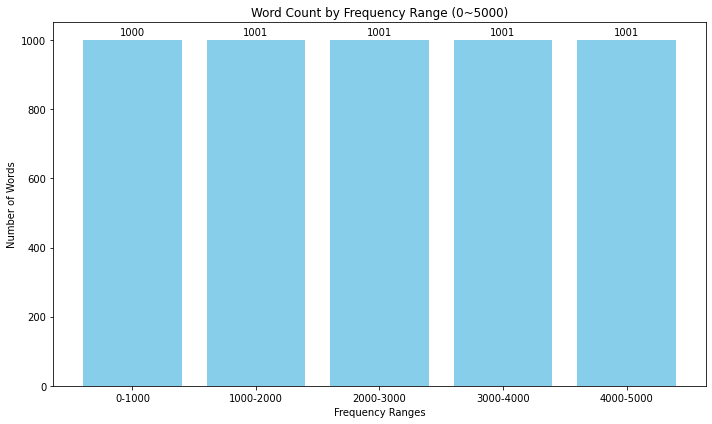

In [182]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

# Reuters 데이터셋의 단어 인덱스 로드
word_index = reuters.get_word_index()

# 빈도 범위 설정 (0~1000, 1000~2000, 2000~3000, 3000~4000, 4000~5000)
frequency_ranges = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000)]

# 빈도 범위별로 단어 개수를 세는 함수
def count_words_in_range(word_index, min_freq, max_freq):
    return sum(min_freq <= index <= max_freq for index in word_index.values())

# 각 범위에 속하는 단어 개수 리스트
word_counts = [count_words_in_range(word_index, min_freq, max_freq) for min_freq, max_freq in frequency_ranges]

# 막대그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar([f"{min_freq}-{max_freq}" for min_freq, max_freq in frequency_ranges], word_counts, color='skyblue')

# 그래프 제목 및 축 레이블 설정
plt.xlabel('Frequency Ranges')
plt.ylabel('Number of Words')
plt.title('Word Count by Frequency Range (0~5000)')

# 막대에 값 추가
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',  # 단어 개수 표시
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 텍스트 위치 조정
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(bars)

# 그래프 보여주기
plt.tight_layout()
plt.show()


- 데이터가 너무 깔끔해서 의심스러움
- 중앙값인 15000으로 설정해봄

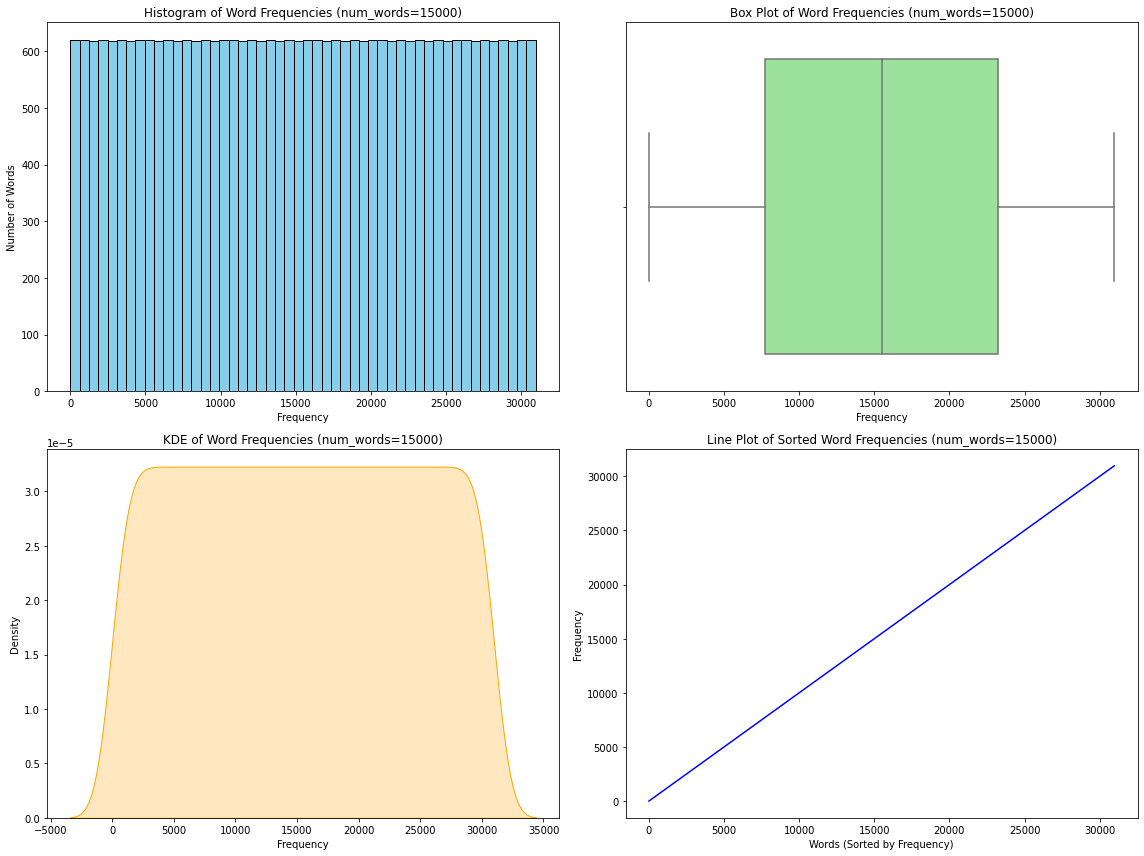

In [184]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import reuters
import seaborn as sns

# Reuters 데이터셋 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

# 단어 인덱스 로드 및 단어 빈도 리스트 생성
word_index = reuters.get_word_index()
word_frequencies = list(word_index.values())

# 1. 히스토그램
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.hist(word_frequencies, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Frequencies (num_words=15000)')
plt.xlabel('Frequency')
plt.ylabel('Number of Words')

# 2. 박스 플롯
plt.subplot(2, 2, 2)
sns.boxplot(x=word_frequencies, color='lightgreen')
plt.title('Box Plot of Word Frequencies (num_words=15000)')
plt.xlabel('Frequency')

# 3. 커널 밀도 추정 (KDE) 그래프
plt.subplot(2, 2, 3)
sns.kdeplot(word_frequencies, color='orange', fill=True)
plt.title('KDE of Word Frequencies (num_words=15000)')
plt.xlabel('Frequency')

# 4. 선 그래프
plt.subplot(2, 2, 4)
sorted_frequencies = sorted(word_frequencies)
plt.plot(sorted_frequencies, color='blue')
plt.title('Line Plot of Sorted Word Frequencies (num_words=15000)')
plt.xlabel('Words (Sorted by Frequency)')
plt.ylabel('Frequency')

# 그래프 레이아웃 조정 및 보여주기
plt.tight_layout()
plt.show()


-----

# 3. 직접 단어 개수 설정

## 1. 데이터 확인하기

* 단어 수에 따라 모델 성능이 어떻게 바뀌는지 실험

In [139]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

- 데이터 출력해보기

In [140]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [141]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [142]:
print(y_train[0])
print(y_test[0])

3
3


In [143]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


- 데이터 분포 확인해보기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


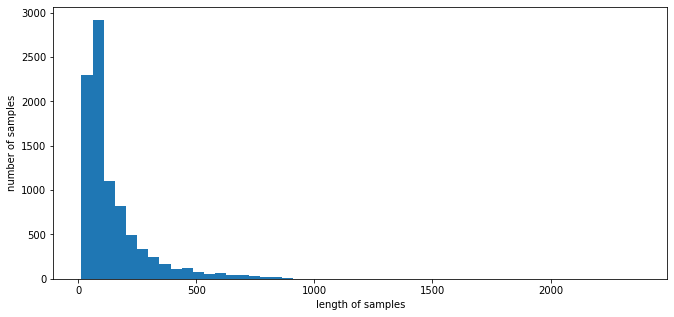

In [144]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

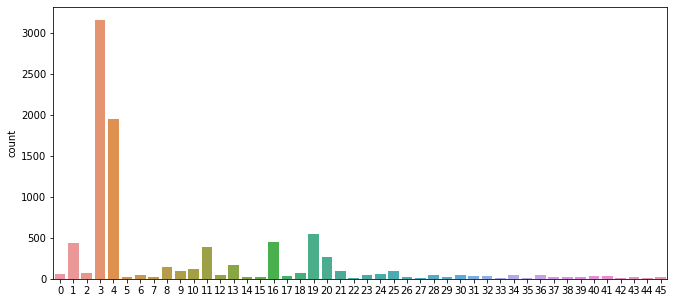

In [145]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [146]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


## 2. 데이터 복원하기

In [147]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print('=3')

=3


In [148]:
word_index['the']

1

In [149]:
word_index['it']

13

In [150]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [151]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [152]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [153]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [154]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [155]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


## 3. 벡터화 하기

- dtm 생성, dtm 크기 확인

In [156]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 14227)


In [157]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 14227)


## - 나이브 베이즈 분류기

In [158]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [159]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_NB_3 = accuracy_score(y_test, predicted) #예측값과 실제값 비교
print("정확도:", acc_NB_3)


정확도: 0.6331255565449688


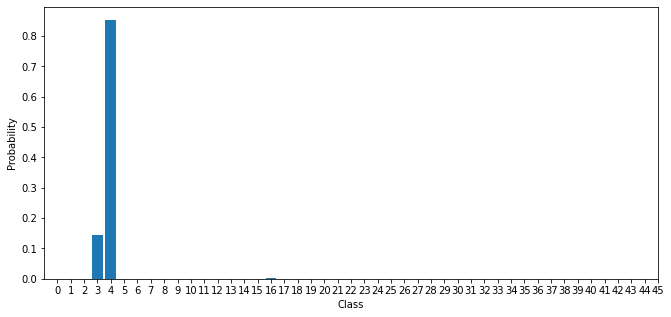

In [160]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [161]:
model.predict(tfidfv_test[3])

array([4])

## - F1-Score, Confusion Matrix

### Precision, Recall & F1 Score

In [162]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.41      0.53        99
          17       0.00    

### Confusion Matrix

In [163]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

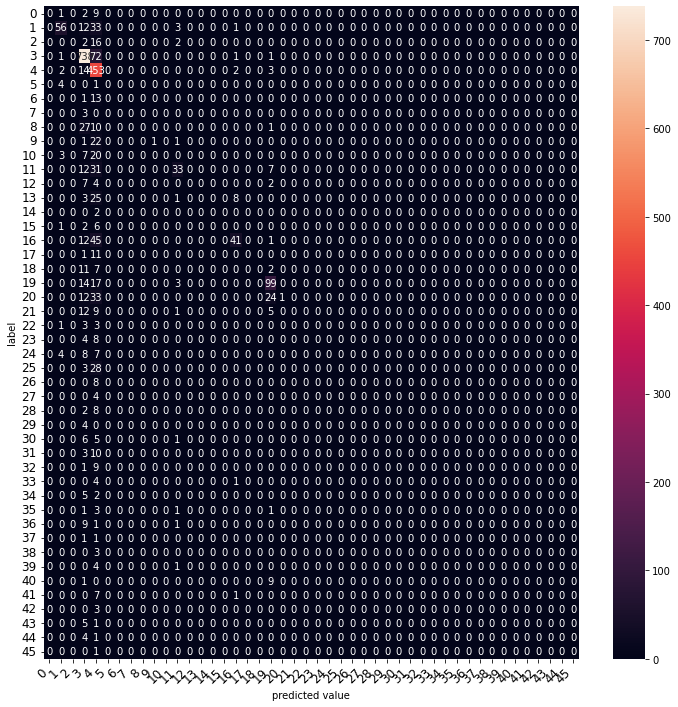

In [164]:
graph_confusion_matrix(model, tfidfv_test, y_test)

# 다양한 머신러닝 모델 사용

## Complement Naive Bayes Classifier(CNB)

In [165]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [166]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_cnb_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_cnb_3) #예측값과 실제값 비교

정확도: 0.7720391807658059


## 로지스틱 회귀(Logistic Regression)

In [167]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [168]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_lr_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_lr_3) #예측값과 실제값 비교

정확도: 0.8147818343722173


## 선형 서포트 벡터 머신(Linear Support Vector Machine)


In [169]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [170]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_lsvc_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_lr_3) #예측값과 실제값 비교

정확도: 0.8147818343722173


## 결정 트리(Decision Tree)

In [171]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [172]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_tree_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_tree_3) #예측값과 실제값 비교

정확도: 0.6193232413178985


## 랜덤 포레스트(Random Forest)

In [173]:
forest = RandomForestClassifier(max_depth = 10)
forest.fit(tfidfv, y_train)

RandomForestClassifier(max_depth=10)

In [174]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_forest_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_forest_3) #예측값과 실제값 비교

정확도: 0.6010685663401603


## 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [175]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [176]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_grbt_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_grbt_3) #예측값과 실제값 비교

정확도: 0.7707034728406055


## 보팅(Voting)

In [177]:
LGBM = LGBMClassifier()

XGB = XGBClassifier()

RF = RandomForestClassifier()

voting_classifier =  VotingClassifier(estimators=[('rf',RF),('xgb',XGB),('lgbm',LGBM)],voting = 'soft')
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:47:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                 

In [178]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc_voting_3 = accuracy_score(y_test, predicted)
print("정확도:", acc_voting_3) #예측값과 실제값 비교

정확도: 0.7266251113089938


# 최종 결과 비교

In [179]:
import pandas as pd

# 첫 번째 결과
results_1 = {
    "Naive Bayes": acc_NB_1,
    "Complement Naive Bayes": acc_cnb_1,
    "Logistic Regression": acc_lr_1,
    "Linear SVC": acc_lsvc_1,
    "Decision Tree": acc_tree_1,
    "Random Forest": acc_forest_1,
    "Gradient Boosting": acc_grbt_1,
    "Voting Classifier": acc_voting_1
}

# 두 번째 결과
results_2 = {
    "Naive Bayes": acc_NB_2,
    "Complement Naive Bayes": acc_cnb_2,
    "Logistic Regression": acc_lr_2,
    "Linear SVC": acc_lsvc_2,
    "Decision Tree": acc_tree_2,
    "Random Forest": acc_forest_2,
    "Gradient Boosting": acc_grbt_2,
    "Voting Classifier": acc_voting_2
}

# 세 번째 결과
results_3 = {
    "Naive Bayes": acc_NB_3,
    "Complement Naive Bayes": acc_cnb_3,
    "Logistic Regression": acc_lr_3,
    "Linear SVC": acc_lsvc_3,
    "Decision Tree": acc_tree_3,
    "Random Forest": acc_forest_3,
    "Gradient Boosting": acc_grbt_3,
    "Voting Classifier": acc_voting_3
}

# 데이터프레임 생성
df = pd.DataFrame({
    'Model': list(results_1.keys()),
    'Accuracy 1': list(results_1.values()),
    'Accuracy 2': list(results_2.values()),
    'Accuracy 3': list(results_3.values())
})

# 출력
print(df)


                    Model  Accuracy 1  Accuracy 2  Accuracy 3
0             Naive Bayes    0.599733    0.673197    0.633126
1  Complement Naive Bayes    0.764915    0.770703    0.772039
2     Logistic Regression    0.816563    0.803651    0.814782
3              Linear SVC    0.797863    0.772930    0.788958
4           Decision Tree    0.621104    0.617988    0.619323
5           Random Forest    0.596171    0.633571    0.601069
6       Gradient Boosting    0.770258    0.767587    0.770703
7       Voting Classifier    0.724399    0.740427    0.726625


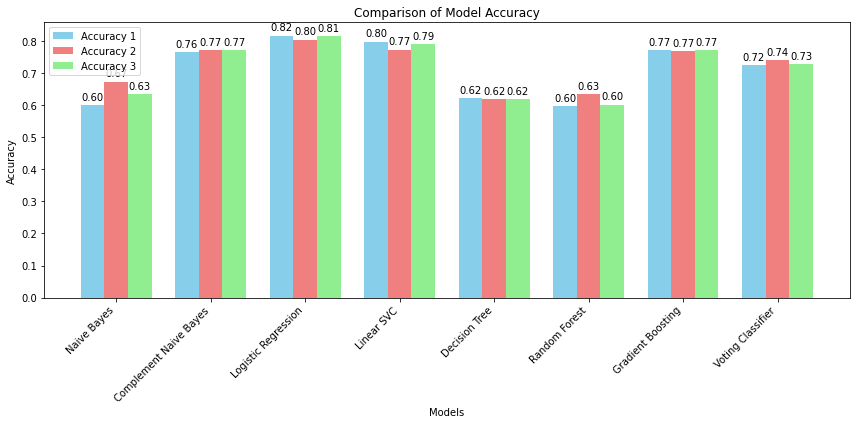

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 이름 리스트
models = ["Naive Bayes", "Complement Naive Bayes", "Logistic Regression", "Linear SVC", 
          "Decision Tree", "Random Forest", "Gradient Boosting", "Voting Classifier"]

# 첫 번째, 두 번째, 세 번째 결과값
accuracy_1 = [acc_NB_1, acc_cnb_1, acc_lr_1, acc_lsvc_1, acc_tree_1, acc_forest_1, acc_grbt_1, acc_voting_1]
accuracy_2 = [acc_NB_2, acc_cnb_2, acc_lr_2, acc_lsvc_2, acc_tree_2, acc_forest_2, acc_grbt_2, acc_voting_2]
accuracy_3 = [acc_NB_3, acc_cnb_3, acc_lr_3, acc_lsvc_3, acc_tree_3, acc_forest_3, acc_grbt_3, acc_voting_3]

# x축 위치 설정
x = np.arange(len(models))  # 모델의 개수만큼 위치 지정
width = 0.25  # 막대의 너비 (세 결과를 나란히 배치하기 위해 축소)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, accuracy_1, width, label='Accuracy 1', color='skyblue')
bars2 = ax.bar(x, accuracy_2, width, label='Accuracy 2', color='lightcoral')
bars3 = ax.bar(x + width, accuracy_3, width, label='Accuracy 3', color='lightgreen')

# 제목과 축 라벨 설정
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")  # x축에 모델 이름 추가
ax.legend()

# 막대에 정확도 값 표시
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # 소수점 두 자리로 정확도 표시
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 텍스트 위치 조정
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# 레이아웃 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()
